In [9]:
import scanpy

#Data handling
from mudata import MuData
import numpy as np
from anndata import AnnData

import pandas as pd
from sklearn.neighbors import kneighbors_graph
import networkx as nx

#Embedding
from node2vec import Node2Vec
from sklearn.manifold import TSNE

#Modelling
from sklearn.mixture import GaussianMixture

#OT
import ot
from gmmot import *

#Plot
from pymnet import *
import seaborn as sns
import matplotlib.pyplot as plt

#GRAPE
import grape
from grape import Graph
from grape.embedders import Node2VecGloVeEnsmallen

rng = np.random.default_rng(seed=42)
%matplotlib inline

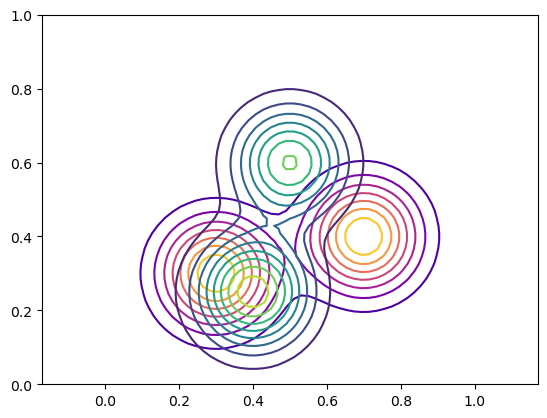

In [5]:
d  = 2 #space dimension

# 2D Gaussian mixtures
K0,K1 = 2,2
pi0 = np.array([[0.5,0.5]])
mu0 = np.array([[0.3,0.3],[0.7,0.4]])
S0 = np.array([[[ .01, 0],[0,  .01]],[[ 0.01, 0],[0,  0.01]]])
pi1 = np.array([[0.45,0.55]])
mu1 = np.array([[0.5,0.6],[0.4,0.25]])
S1 = np.array([[[ .01, 0],[0,  .01]],[[ 0.01, 0],[0,  0.01]]])

# display
n=50    
x = np.linspace(0, 1,num=n)
y = np.linspace(0, 1,num=n)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = densite_theorique2d(mu0,S0,pi0,XX)
Z = Z.reshape(X.shape)
Z2 = densite_theorique2d(mu1,S1,pi1,XX,)
Z2 = Z2.reshape(X.shape)
CS = plt.contour(X, Y, Z,8,cmap='plasma')
CS = plt.contour(X, Y, Z2,8,cmap='viridis')
plt.axis('equal');   

In [6]:
def load_layers(id):
    ccnet = pd.read_csv(id+'_layer_scRNAcellTypes.csv',index_col=0)
    ccspotnet = pd.read_csv(id+'_layer_mapping.csv',index_col=0)
    spotnet = pd.read_csv(id+'_layer_spot.csv',index_col=0)
    return ccnet, ccspotnet, spotnet

def graph_from_layers(ccnet, ccspotnet, spotnet):
    ccnetgraph = kneighbors_graph(ccnet, 5, mode='distance', include_self=False)
    spotnetgraph = kneighbors_graph(spotnet, 10, mode='distance', include_self=False)
    ccspotnet = ccspotnet.loc[:,ccnet.index]

    spotnetgraph = nx.from_pandas_adjacency(pd.DataFrame(spotnetgraph.todense(),
                                                   index=spotnet.index,
                                                   columns=spotnet.index))
    
    ccnetgraph = nx.from_pandas_adjacency(pd.DataFrame(ccnetgraph.todense(),
                                                   index=ccnet.index,
                                                   columns=ccnet.index))
    
    cc2spotgraph = nx.Graph()
    for i in range(ccspotnet.shape[0]):
        u = i
        for j in enumerate(ccspotnet.iloc[i,ccspotnet.iloc[i,:].argsort().tolist()[::-1]]):
            if j[0] <5:
                tmp=ccspotnet.iloc[i,ccspotnet.iloc[i,:].argsort().tolist()[::-1]].index[j[0]]
                cc2spotgraph.add_edge(u_of_edge=u,v_of_edge=tmp,weight=1-j[1])

    print(ccnetgraph, cc2spotgraph, spotnetgraph)
    return ccnetgraph, cc2spotgraph, spotnetgraph

def unigraph2vec(g):
    # Precompute probabilities and generate walks - **ON WINDOWS ONLY WORKS WITH workers=1**
    node2vec = Node2Vec(g, dimensions=10, walk_length=30, num_walks=200, workers=8)  # Use temp_folder for big graphs

    # Embed nodes
    model = node2vec.fit(window=10, min_count=1, batch_words=4)  # Any keywords acceptable by gensim.Word2Vec can be passed, `dimensions` and `workers` are automatically passed (from the Node2Vec constructor)

    # Look for most similar nodes
    #model.wv.most_similar('2')  # Output node names are always strings
    node_embeddings = (model.wv.vectors)
    return node_embeddings

def fast_unigraph2vec(g):
    g=grape.Graph(g)
    # Embed nodes
    node_embedding  = Node2VecGloVeEnsmallen().fit_transform(g)  # Any keywords acceptable by gensim.Word2Vec can be passed, `dimensions` and `workers` are automatically passed (from the Node2Vec constructor)
    return node_embeddings
    
def t_SNE(embedded_ND):   
    embedded_2D = TSNE(n_components=2, learning_rate='auto',
                    init='random', perplexity=3).fit_transform(embedded_ND)
    return embedded_2D
    
def plot_2D(embedded_2D, node_label):
    df = pd.DataFrame(embedded_2D, columns=['x','y'])
    #x, y = embedded_2D.T
    df['label'] = node_label

    #fig, axes = plt.subplots(1, 2)
    sns.set(rc={'figure.figsize':(12,8)})
    ax = sns.scatterplot(df, x='x',y='y',hue="label") #,ax=axes[0])

    plt.subplots_adjust(right=0.7)
    if len(nodel_label)<50:
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize="8")
    plt.title("t-SNE of Embedded Nodes (corresponding to Celltypes)")

    ax.get_figure().savefig("node_embedding_celltype.png")

    plt.show()

def GMM(euclidean_data,n_classes=5):

    n_classes = 5
    colors = sns.color_palette("Set2",n_classes)

    def make_ellipses(gmm, ax):
        for n, color in enumerate(colors):
            if gmm.covariance_type == "full":
                covariances = gmm.covariances_[n][:2, :2]
            elif gmm.covariance_type == "tied":
                covariances = gmm.covariances_[:2, :2]
            elif gmm.covariance_type == "diag":
                covariances = np.diag(gmm.covariances_[n][:2])
            elif gmm.covariance_type == "spherical":
                covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
            v, w = np.linalg.eigh(covariances)
            u = w[0] / np.linalg.norm(w[0])
            angle = np.arctan2(u[1], u[0])
            angle = 180 * angle / np.pi  # convert to degrees
            v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
            ell = mpl.patches.Ellipse(
                gmm.means_[n, :2], v[0], v[1], angle=180 + angle, color=color
            )
            ell.set_clip_box(ax.bbox)
            ell.set_alpha(0.5)
            ax.add_artist(ell)
            ax.set_aspect("equal", "datalim")

    # Try GMMs using different types of covariances.
    estimators = {
        cov_type: GaussianMixture(
            n_components=n_classes, covariance_type=cov_type, max_iter=20, random_state=0
        )
        for cov_type in ["spherical", "diag", "tied", "full"]
    }

    n_estimators = len(estimators)

    plt.figure(figsize=(3 * n_estimators // 2, 6))
    plt.subplots_adjust(
        bottom=0.01, top=0.95, hspace=0.15, wspace=0.05, left=0.01, right=0.99
    )

    tmp_estimator = None
    for index, (name, estimator) in enumerate(estimators.items()):
        # Since we have class labels for the training data, we can
        # initialize the GMM parameters in a supervised manner.
        
        #estimator.means_init = np.array(
        #    [X_train[y_train == i].mean(axis=0) for i in range(n_classes)]
        #)

        # Train the other parameters using the EM algorithm.
        estimator.fit(euclidean_data)

        h = plt.subplot(2, n_estimators // 2, index + 1)
        make_ellipses(estimator, h)

        plt.scatter(euclidean_data[:, 0],euclidean_data[:, 1]) #,label=node_label)
        '''
        for n, color in enumerate(colors):
            data = iris.data[iris.target == n]
            plt.scatter(
                data[:, 0], data[:, 1], s=0.8, color=color, label=iris.target_names[n]
            )

        # Plot the test data with crosses
        for n, color in enumerate(colors):
            data = X_test[y_test == n]
            plt.scatter(data[:, 0], data[:, 1], marker="x", color=color)
        '''

        #y_train_pred = estimator.predict(X_train)
        #train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel()) * 100
        #plt.text(0.05, 0.9, "Train accuracy: %.1f" % train_accuracy, transform=h.transAxes)

        #y_test_pred = estimator.predict(X_test)
        #test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel()) * 100
        #plt.text(0.05, 0.8, "Test accuracy: %.1f" % test_accuracy, transform=h.transAxes)

        plt.xticks(())
        plt.yticks(())
        plt.title(name)
        tmp_estimator = estimator

    #plt.legend(scatterpoints=1, loc="lower right", prop=dict(size=12))




    plt.savefig("GMM.png")
    plt.show()

    return tmp_estimator


In [ ]:
h_layers = load_layers("RZ_P9")
h_cc, h_c2s, h_ss  = graph_from_layers(*h_layers)

i_layers = load_layers("GT_IZ_P9")
i_cc, i_c2s, i_ss  = graph_from_layers(*i_layers)



Graph with 33 nodes and 97 edges Graph with 3655 nodes and 18130 edges Graph with 3626 nodes and 18831 edges


In [13]:
help(grape.Graph)
grape.Graph().incoming_graph_data(h_c2s)

Help on class Graph in module ensmallen:

class Graph(builtins.object)
 |  This is the main struct in Ensmallen, it allows to load and manipulate Graphs efficently.
 |  You are not supposed to directly instantiate this struct but instead you should use the
 |  static method `from_csv`, which allows to load the graph from an edge-list.
 |  
 |  To get information about a loaded graph, you can call the `textual_report` method which
 |  generates an human-readable HTML report.
 |  
 |  By default we use EliasFano to store the Adjacency Matrix, this allows to save memory but
 |  is slower than a CSR. For this reason you can use the `enable` method to enable optimizzations
 |  which speeds up the operations at the cost of more memory usage. You can check the memory usage
 |  in bytes using `get_total_memory_used` and you can get a detailed memory report of each data-structure
 |  inside Graph using `memory_stats`.
 |  
 |  You can pre-compute the memory needed (in bits) to store the adjacen

TypeError: No constructor defined

In [ ]:

iterations = 2

healthy = []
ischemic = []

for i in range(iterations):

    print("healthy")
    cc1_embedded = fast_unigraph2vec(h_c2s)
    cc1_tSNE = t_SNE(cc1_embedded)
    plot_2D(cc1_tSNE,list(h_c2s.nodes))
    healthy.append(GMM(cc1_tSNE,n_classes=5))

    print("ischemic")
    cc2_embedded = fast_unigraph2vec(i_c2s)
    cc2_tSNE = t_SNE(cc2_embedded)
    plot_2D(cc2_tSNE,list(i_c2s.nodes))
    ischemic.append(GMM(cc2_tSNE,n_classes=5))



In [4]:
np.set_printoptions(suppress=True)

def wasserstein_dist(GMM0,GMM1):
    K0,d = GMM0.means_.shape
    K1, _ = GMM1.means_.shape

    pi0=GMM0.weights_
    mu0=GMM0.means_
    S0=GMM0.covariances_

    pi1=GMM1.weights_
    mu1=GMM1.means_
    S1=GMM1.covariances_

    wstar,dist = GW2(np.ravel(pi0),np.ravel(pi1),mu0.reshape(K0,d),mu1.reshape(K1,d),S0.reshape(K0,d,d),S1.reshape(K1,d,d))
    return dist


dist = np.zeros((2*iterations,2*iterations))
for i,mmt1 in enumerate(healthy + ischemic):
    for j,mmt2 in enumerate(healthy + ischemic):
        dist[i,j]=wasserstein_dist(mmt1,mmt2)

print(dist)

NameError: name 'iterations' is not defined

(5,)
(5, 2)
(5, 2, 2)


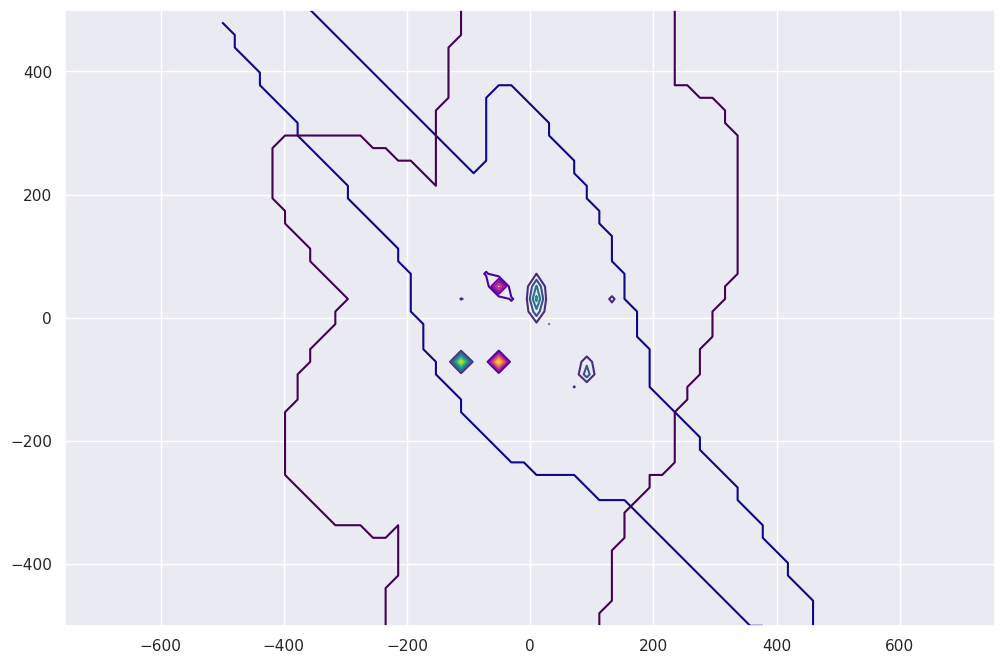

In [ ]:


#OT between
d = 2 #dims

K0,K1 = 5,5
pi0=healthy[0].weights_
mu0=healthy[0].means_
S0=healthy[0].covariances_
#S 
#Z2 = densite_theorique2d(mu0,S01,pi0,XX,)

#pi1=ischemic[0].weights_
#mu1=ischemic[0].means_
#S1=ischemic[0].covariances_


pi1=healthy[1].weights_
mu1=healthy[1].means_
S1=healthy[1].covariances_
#S




# display
n=50    
x = np.linspace(-500, 500,num=n)
y = np.linspace(-500, 500,num=n)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = densite_theorique2d(mu0,S0,pi0,XX)
Z = Z.reshape(X.shape)
Z2 = densite_theorique2d(mu1,S1,pi1,XX,)
Z2 = Z2.reshape(X.shape)
CS = plt.contour(X, Y, Z,8,cmap='plasma')
CS = plt.contour(X, Y, Z2,8,cmap='viridis')
plt.axis('equal');   
#weights_
#means_
#


In [ ]:

#gmm0 = densite_theorique(mu0,S0,pi0,x)
#gmm0 = gmm0/gmm0.sum()
#gmm1 = densite_theorique(mu1,S1,pi1,x)
#gmm1 = gmm1/gmm1.sum()
#G0 = ot.emd(gmm0, gmm1, M)
#plt.figure(3, figsize=(5, 5))
#ot.plot.plot1D_mat(gmm0, gmm1, G0, 'OT matrix G0')

wstar,dist = GW2(np.ravel(pi0),np.ravel(pi1),mu0.reshape(K0,d),mu1.reshape(K1,d),S0.reshape(K0,d,d),S1.reshape(K1,d,d))
wstar
dist

4200.020461885622

Graph with 33 nodes and 97 edges Graph with 3655 nodes and 18130 edges Graph with 3626 nodes and 18831 edges
Graph with 29 nodes and 87 edges Graph with 4386 nodes and 21805 edges Graph with 4361 nodes and 22735 edges


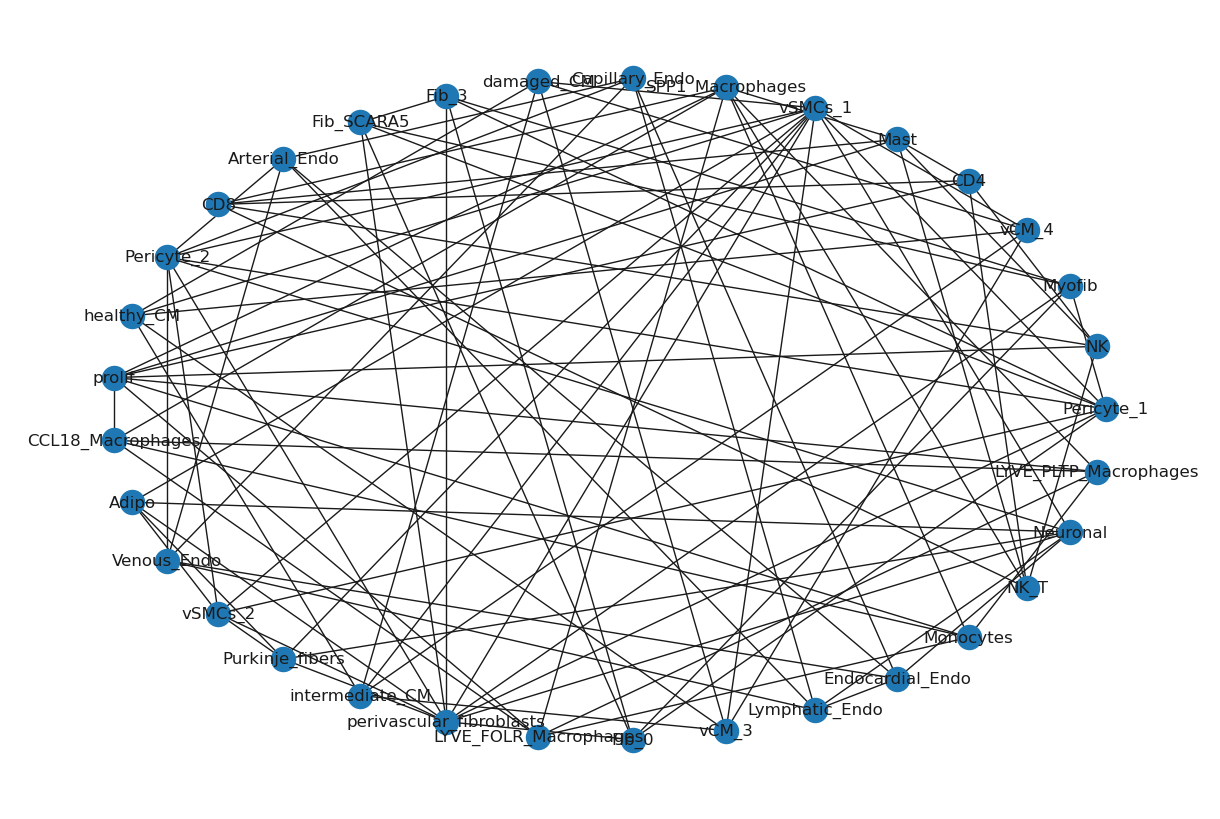

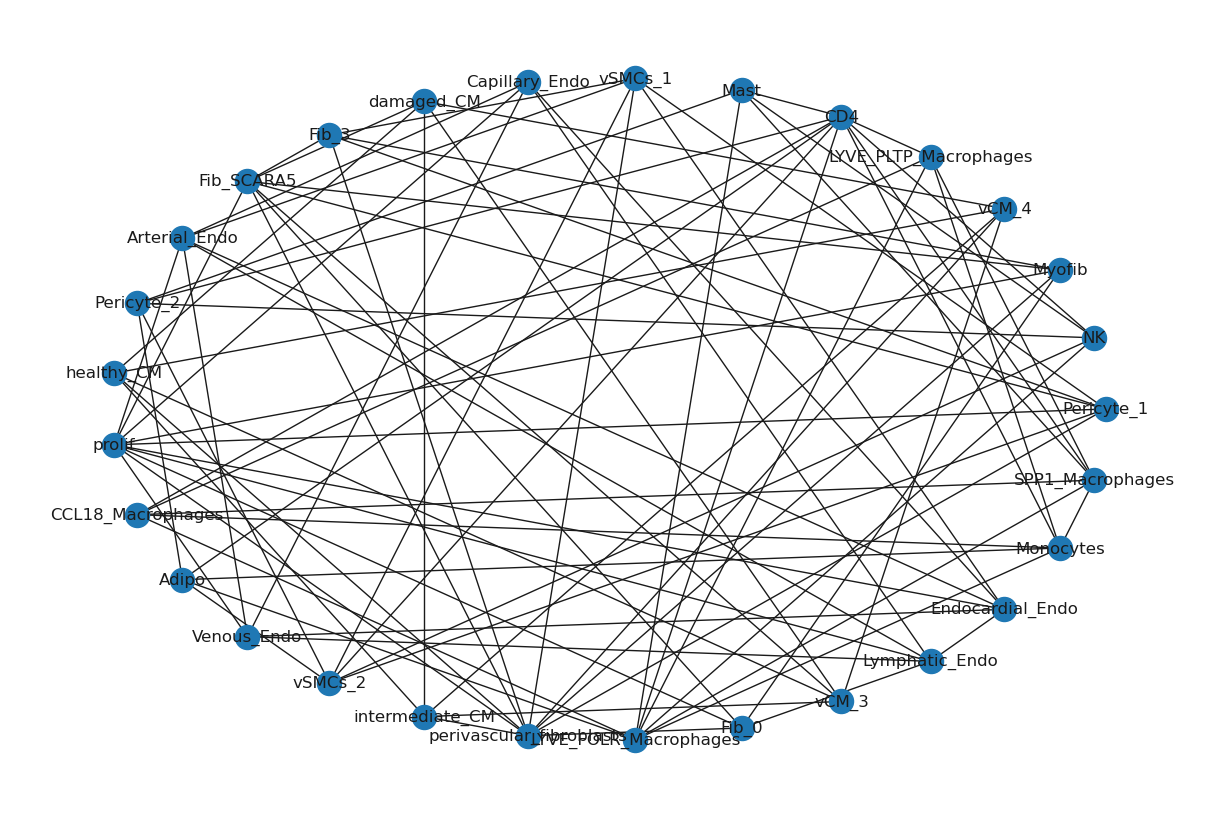

In [ ]:
'''

#ccnet = pd.read_csv('RZ_P9_layer_mapping.csv',index_col=0)
#ccnetgraph = kneighbors_graph(ccnet, 5, mode='distance', include_self=False)
#ccnetgraph = nx.from_pandas_adjacency(pd.DataFrame(ccnetgraph.todense(),
#                                                   index=ccnet.index,
#                                                   columns=ccnet.index))

layers = load_layers("RZ_P9")
#print(layers)
#
cc1, c2s1, ss1  = graph_from_layers(*layers)

plt.figure(1)
nx.draw_kamada_kawai(cc1,with_labels=True)

#ccnet2 = pd.read_csv('GT_IZ_P9_layer_mapping.csv',index_col=0)
#ccnetgraph2 = kneighbors_graph(ccnet2, 5, mode='distance', include_self=False)
#ccnetgraph2 = nx.from_pandas_adjacency(pd.DataFrame(ccnetgraph2.todense(),
#                                                   index=ccnet2.index,
#                                                   columns=ccnet2.index))

layers = load_layers("GT_IZ_P9")
#print(layers)
#
cc2, c2s2, ss2  = graph_from_layers(*layers)


plt.figure(2)
nx.draw_kamada_kawai(cc2,with_labels=True)
'''

Generating walks (CPU: 6): 100%|██████████| 62/62 [00:00<00:00, 434.62it/s]


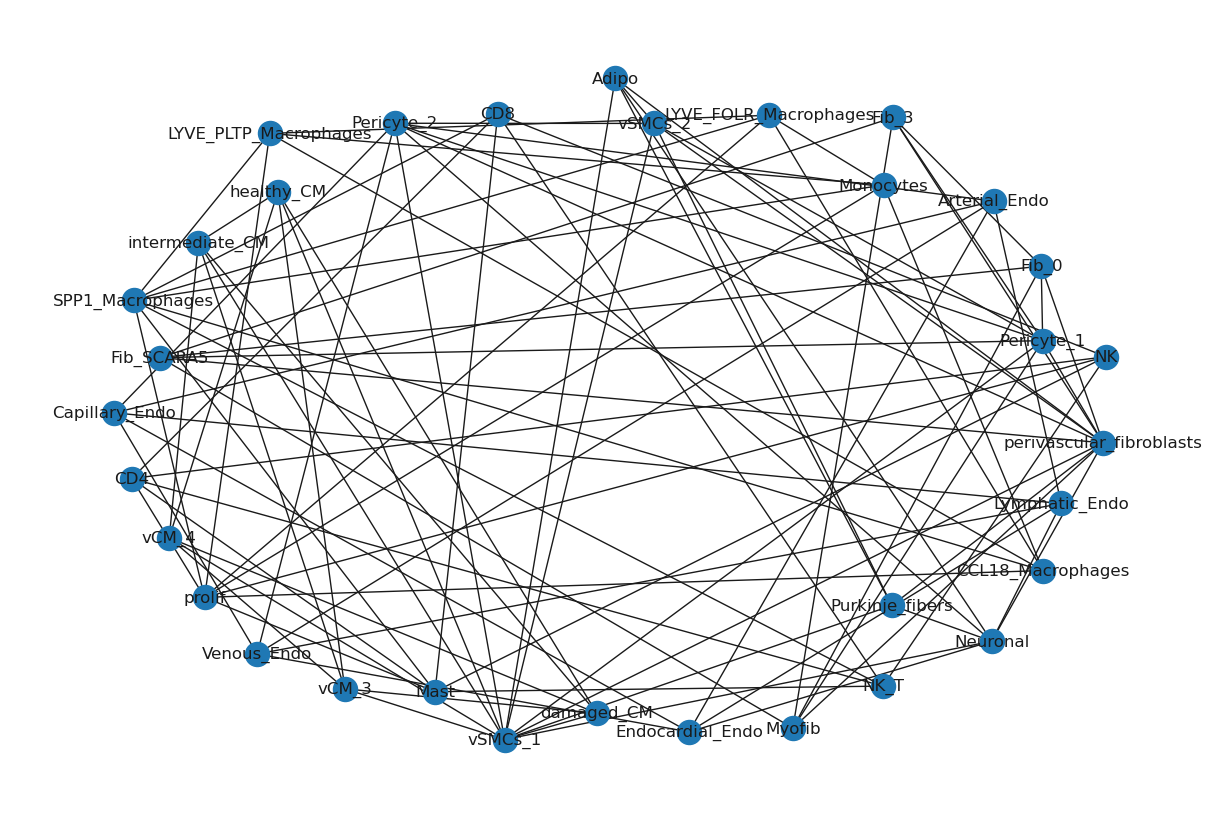

In [ ]:
#Node Embedding
# Create a graph
#graph = nx.fast_gnp_random_graph(n=100, p=0.5)
graph = ccnetgraph
nx.draw(graph,with_labels=True)

# Precompute probabilities and generate walks - **ON WINDOWS ONLY WORKS WITH workers=1**
node2vec = Node2Vec(graph, dimensions=64, walk_length=30, num_walks=500, workers=8)  # Use temp_folder for big graphs

# Embed nodes
model = node2vec.fit(window=10, min_count=1, batch_words=4)  # Any keywords acceptable by gensim.Word2Vec can be passed, `dimensions` and `workers` are automatically passed (from the Node2Vec constructor)

# Look for most similar nodes
#model.wv.most_similar('2')  # Output node names are always strings
node_embeddings = (model.wv.vectors)



In [ ]:
node_label = list(ccnetgraph.nodes)

In [ ]:
from sklearn.manifold import TSNE

embedded_2D = TSNE(n_components=2, learning_rate='auto',
                   init='random', perplexity=3).fit_transform(node_embeddings)


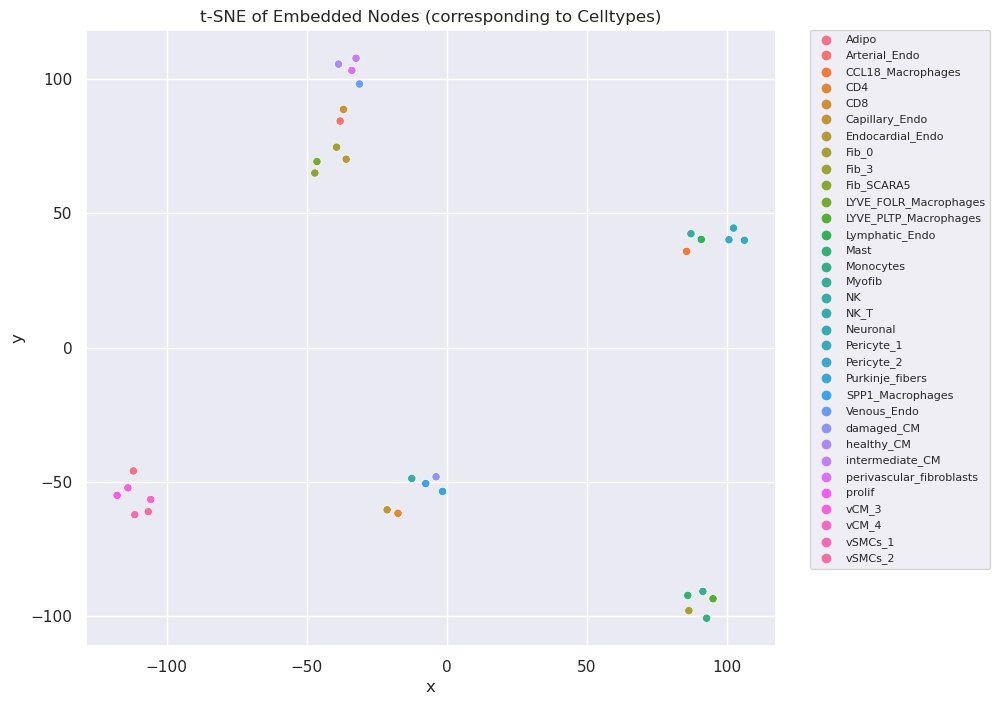

In [ ]:
import matplotlib.pyplot as plt

df = pd.DataFrame(embedded_2D, columns=['x','y'])
#x, y = embedded_2D.T
df['label'] = node_label

#fig, axes = plt.subplots(1, 2)
sns.set(rc={'figure.figsize':(12,8)})
ax = sns.scatterplot(df, x='x',y='y',hue="label") #,ax=axes[0])

plt.subplots_adjust(right=0.7)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize="8")
plt.title("t-SNE of Embedded Nodes (corresponding to Celltypes)")

ax.get_figure().savefig("node_embedding_celltype.png")

plt.show()

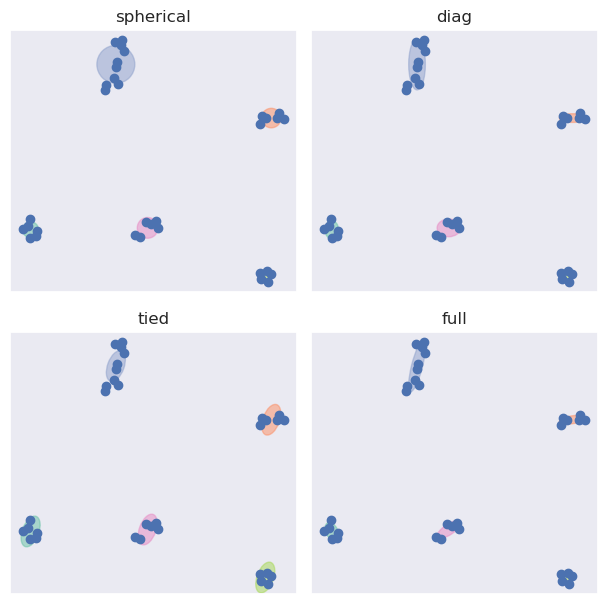

In [ ]:
import matplotlib as mpl

n_classes = 5
colors = sns.color_palette("Set2",5)

def make_ellipses(gmm, ax):
    for n, color in enumerate(colors):
        if gmm.covariance_type == "full":
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == "tied":
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == "diag":
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == "spherical":
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        ell = mpl.patches.Ellipse(
            gmm.means_[n, :2], v[0], v[1], angle=180 + angle, color=color
        )
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        ax.set_aspect("equal", "datalim")

# Try GMMs using different types of covariances.
estimators = {
    cov_type: GaussianMixture(
        n_components=n_classes, covariance_type=cov_type, max_iter=20, random_state=0
    )
    for cov_type in ["spherical", "diag", "tied", "full"]
}

n_estimators = len(estimators)

plt.figure(figsize=(3 * n_estimators // 2, 6))
plt.subplots_adjust(
    bottom=0.01, top=0.95, hspace=0.15, wspace=0.05, left=0.01, right=0.99
)


for index, (name, estimator) in enumerate(estimators.items()):
    # Since we have class labels for the training data, we can
    # initialize the GMM parameters in a supervised manner.
    
    #estimator.means_init = np.array(
    #    [X_train[y_train == i].mean(axis=0) for i in range(n_classes)]
    #)

    # Train the other parameters using the EM algorithm.
    estimator.fit(embedded_2D)

    h = plt.subplot(2, n_estimators // 2, index + 1)
    make_ellipses(estimator, h)

    plt.scatter(embedded_2D[:, 0],embedded_2D[:, 1]) #,label=node_label)
    '''
    for n, color in enumerate(colors):
        data = iris.data[iris.target == n]
        plt.scatter(
            data[:, 0], data[:, 1], s=0.8, color=color, label=iris.target_names[n]
        )

    # Plot the test data with crosses
    for n, color in enumerate(colors):
        data = X_test[y_test == n]
        plt.scatter(data[:, 0], data[:, 1], marker="x", color=color)
    '''

    #y_train_pred = estimator.predict(X_train)
    #train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel()) * 100
    #plt.text(0.05, 0.9, "Train accuracy: %.1f" % train_accuracy, transform=h.transAxes)

    #y_test_pred = estimator.predict(X_test)
    #test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel()) * 100
    #plt.text(0.05, 0.8, "Test accuracy: %.1f" % test_accuracy, transform=h.transAxes)

    plt.xticks(())
    plt.yticks(())
    plt.title(name)

#plt.legend(scatterpoints=1, loc="lower right", prop=dict(size=12))




plt.savefig("GMM.png")
plt.show()


In [ ]:
'''
# Save embeddings for later use
#model.wv.save_word2vec_format(EMBEDDING_FILENAME)

# Save model for later use
#model.save(EMBEDDING_MODEL_FILENAME)

# Embed edges using Hadamard method
from node2vec.edges import HadamardEmbedder

edges_embs = HadamardEmbedder(keyed_vectors=model.wv)

# Look for embeddings on the fly - here we pass normal tuples
edges_embs[('1', '2')]
''' OUTPUT
array([ 5.75068220e-03, -1.10937878e-02,  3.76693785e-01,  2.69105062e-02,
       ... ... ....
       ..................................................................],
      dtype=float32)
'''

# Get all edges in a separate KeyedVectors instance - use with caution could be huge for big networks
edges_kv = edges_embs.as_keyed_vectors()

# Look for most similar edges - this time tuples must be sorted and as str
edges_kv.most_similar(str(('1', '2')))

# Save embeddings for later use
#edges_kv.save_word2vec_format(EDGES_EMBEDDING_FILENAME)

edges_kv
'''

SyntaxError: invalid syntax (2592645173.py, line 15)

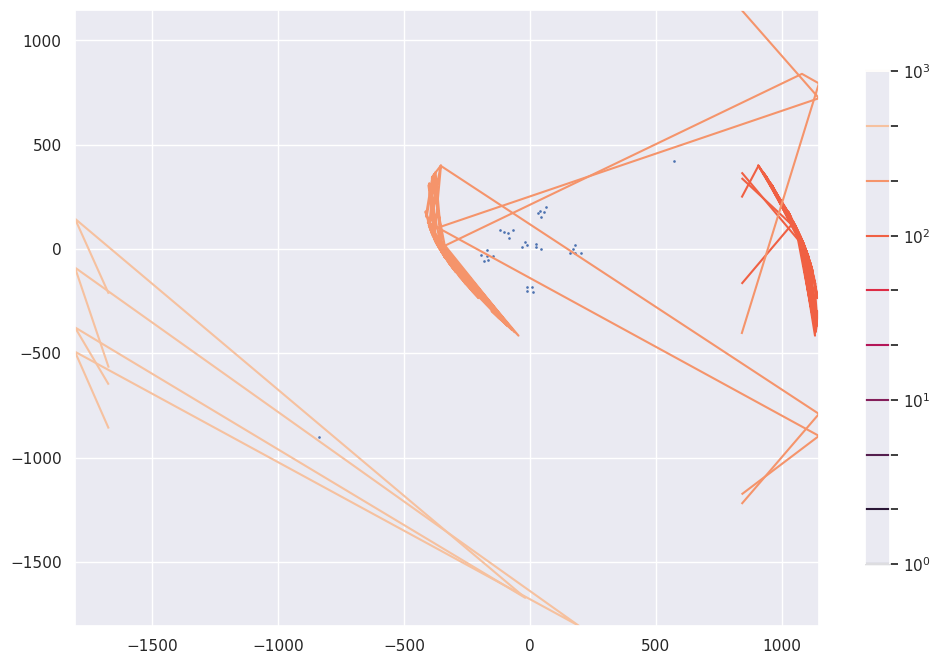

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

#Gaussian Mixture Model
gm = GaussianMixture(n_components=5, random_state=0).fit(embedded_2D)
gm.means_


#gm.predict([[0, 0], [12, 3]])
# display predicted scores by the model as a contour plot
x = np.linspace(np.amin(embedded_2D,axis=0)*2, np.amax(embedded_2D,axis=0)*2,num=2)
y = np.linspace(np.amin(embedded_2D,axis=1)*2, np.amax(embedded_2D,axis=1)*2,num=2)

X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -gm.score_samples(XX)
Z = Z.reshape(X.shape)

CS = plt.contour(
    X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0), levels=np.logspace(0, 3, 10)
)
CB = plt.colorbar(CS, shrink=0.8, extend="both")
plt.scatter(embedded_2D[:, 0], embedded_2D[:, 1], 0.8)

In [ ]:
#OT between GMM (Nodes of Patient)


In [ ]:
#OT between Distances of GMM (Graphs of Patients)